In [1]:
import pandas as pd
import torch
from torch import nn
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from tqdm import tqdm
import re

In [3]:
seq_path = r"E:\Archive\PG_at_UCL\bioinfo\paralogs of PGH2.txt"
p_list = []
with open(seq_path, 'r') as f:
    contents = f.readlines()
    for content in contents:
        if re.match(r'\w', content):
            p_list.append(content)
print(len(p_list))


6


In [4]:
def Get_Protein_Feature(p_list, truncation_length:int = 2046):
    client = ESMC.from_pretrained("esmc_600m").to("cuda")
    batch = 20
    data_tmp = []
    output = []
    dictionary = {}
    for p in p_list:
        data_tmp.append(p)

    pbar0 = tqdm(range(len(data_tmp)//batch + 1), position=0, colour='cyan')
    for i in pbar0:
        torch.cuda.empty_cache()
        if i == len(data_tmp)//batch:
            data_part = data_tmp[i * batch:]
        else:
            data_part = data_tmp[i * batch:(i + 1) * batch]
        #proteins = [ESMProtein(sequence = s) for s in data_part]
        
        for p in data_part:
            proteins = ESMProtein(sequence = p)

            protein_tensors = client.encode(proteins)
            logits_output = client.logits(
                protein_tensors, 
                LogitsConfig(sequence=True, return_embeddings=True)
            )
            embbeding_output = logits_output.embeddings.squeeze().cpu().numpy().mean(0)
            dictionary[p] = embbeding_output
            df = pd.DataFrame(dictionary.items(), columns=['seq', 'esm'])
            #output.append(embbeding_output.squeeze())
    return df

df = Get_Protein_Feature(p_list)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


In [6]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
dist_matrix = squareform(pdist(df['esm'].tolist(), metric="cosine"))

In [37]:
dist_matrix

array([[0.        , 0.00985461, 0.02351396, 0.03357905, 0.0657592 ,
        0.06006087],
       [0.00985461, 0.        , 0.02336794, 0.02957938, 0.04724231,
        0.0534528 ],
       [0.02351396, 0.02336794, 0.        , 0.02050943, 0.0464125 ,
        0.05304866],
       [0.03357905, 0.02957938, 0.02050943, 0.        , 0.02516352,
        0.01455084],
       [0.0657592 , 0.04724231, 0.0464125 , 0.02516352, 0.        ,
        0.03582288],
       [0.06006087, 0.0534528 , 0.05304866, 0.01455084, 0.03582288,
        0.        ]])

C:\Users\hp\AppData\Local\Temp\ipykernel_11096\2337145519.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  z = linkage(dist_matrix, 'ward')


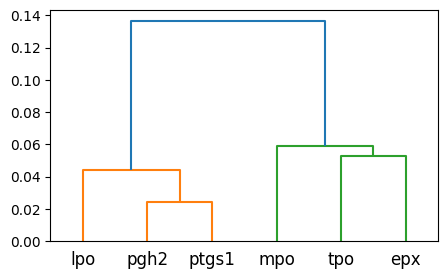

<Figure size 640x480 with 0 Axes>

In [10]:
z = linkage(dist_matrix, 'ward')
f = fcluster(z,10000,'distance')
plt.figure(figsize=(5, 3))
dn = dendrogram(z, labels=['pgh2', 'ptgs1', 'lpo', 'mpo', 'tpo', 'epx'])
plt.show()
plt.savefig('embedding_for_msa.png', dpi = 600)